In [1]:
import numpy as np
import os

from pydrake.common import FindResourceOrThrow, temp_directory
from pydrake.geometry import (
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Role,
    StartMeshcat,
)
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.meshcat import JointSliders
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder

# for InverseDynamicsController
from pydrake.systems.controllers import InverseDynamicsController

# for SVG system diagram
import pydot
from IPython.display import SVG, display, Image
from pydrake.systems.primitives import LogVectorOutput

# for video recording
from pydrake.geometry.render import (
    ClippingRange,
    ColorRenderCamera,
    DepthRange,
    DepthRenderCamera,
    RenderCameraCore,
    RenderLabel,
    MakeRenderEngineVtk,
    RenderEngineVtkParams,
)

import pydrake.visualization

# for trajectory plots
import matplotlib.pyplot as plt


In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


### Build a system using `DiagramBuilder`
- clearing up Meshcat might be necessary if you build systems multiple times

In [7]:
meshcat.Delete()
meshcat.DeleteAddedControls()
builder = DiagramBuilder()


#### Add a Cart-Pole MultibodyPlant (and a SceneGraphe)
- fully actuated, 2 actuations
- loaded from `carpole_BSA.sdf`

In [8]:
# Note: the time_step here is chosen arbitrarily.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)

# Load the file into the plant/scene_graph.
parser = Parser(plant)
parser.AddModelFromFile("cartpole_BSA.sdf")
plant.Finalize()


#### Add an InverseDynamicsController
- PID parameters are tuned by some trial and error
- a logger is added
    - for plotting
- The Cart-Pole system and InverseDynamicsController are wired below

In [9]:
# fully actuated cartpole has 2 actuations
# these parameters are tuned by some trial and error
kp = np.asarray([5., 2])
kd = np.asarray([0.1, 0.1])
ki = np.asarray([1., 1])

inv_dyn_controller = builder.AddSystem(InverseDynamicsController(plant, kp, kd, ki, False))
inv_dyn_controller.set_name("inverse dynamics controller")

# InverseDynamicsController takes 2 ("desired_state", "estimated_state") inputs
# Make the "desired_state" input of the controller is an input to the diagram.
builder.ExportInput(inv_dyn_controller.get_input_port_desired_state(), name="target")

# the "estimated_state" input of the controller is connected to the "state" output of the cartpole
# so it is not just an estimated state. it is an actual state
builder.Connect(plant.get_state_output_port(), inv_dyn_controller.get_input_port_estimated_state())

# InverseDynamicsController calculates actuations for the cartpole
builder.Connect(inv_dyn_controller.get_output_port_control(), plant.get_actuation_input_port())

# Log the state of the cartpole.
logger = LogVectorOutput(plant.get_state_output_port(), builder)
logger.set_name("logger")

#### Add visualizers

In [10]:
# Add two visualizers, one to publish the "visual" geometry, and
# the other to publish the "collision" geometry.
visual = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat,
    MeshcatVisualizerParams(role=Role.kPerception, prefix="visual"))

collision = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat,
    MeshcatVisualizerParams(role=Role.kProximity, prefix="collision"))

# Disable the collision geometry at the start; it can be enabled by the
# checkbox in the meshcat controls.
meshcat.SetProperty("collision", "visible", False)

diagram = builder.Build()


#### system diagram
- it even shows the internals of MultibodyPlant and InverseDynamicsController

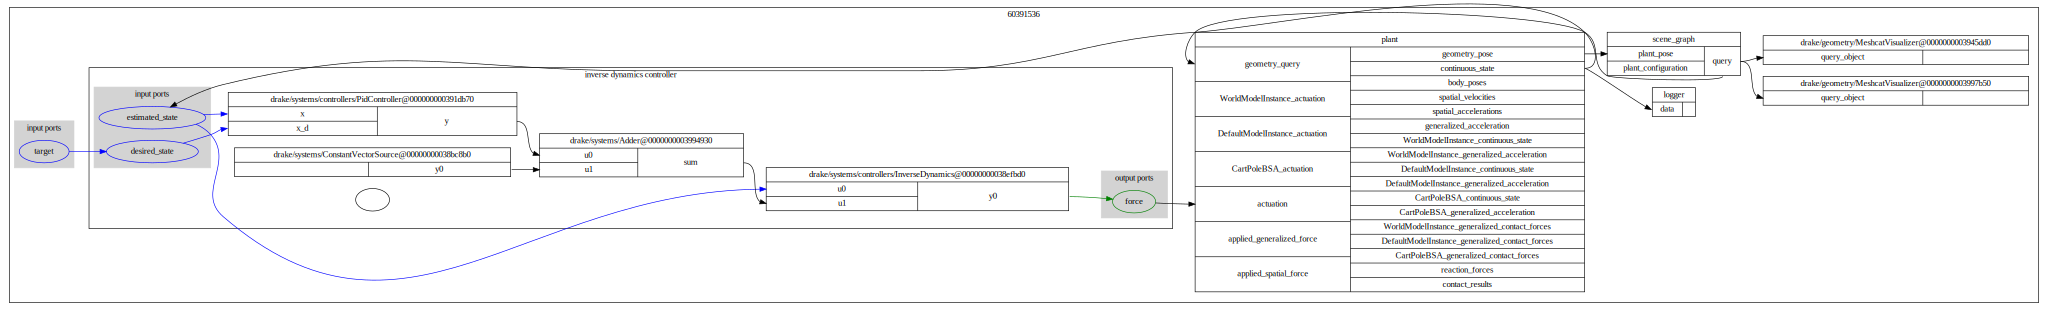

In [11]:
g = pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0]
with open("./Media/system_diagram.svg", "wb") as f:
    f.write(g.create_svg())

svg = SVG(g.create_svg())

display(svg)

### Simulation
- initial state is arbitrarily choosen to be $(0.2, 0.2, 0, 0)$
- target state is the quiescent state at the origin, which is $(0, 0, 0, 0)$
- simulated from $t=0 \, s$ up to $t=10 \, s$
    - simulations are recorded for later replays and exportings

In [12]:
# Set up a simulator to run this diagram.
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)

context = simulator.get_mutable_context()
plant_context = diagram.GetMutableSubsystemContext(plant, context)

# initial state
plant_context.get_mutable_discrete_state_vector().SetFromVector([0.2, 0.2, 0., 0.])

# target state
diagram.get_input_port(0).FixValue(context, [0.0, 0.0, 0, 0])

# Clear the logger only because we've written this notebook with the opportunity to
# simulate multiple times (in this cell) using the same logger object.  This is
# often not needed.
logger.FindMutableLog(context).Clear()

# for video recording export
visual.StartRecording()
simulator.AdvanceTo(10)
visual.StopRecording()

In [13]:
visual.PublishRecording()

### Simulation results
- for this particular initial state and PID parameters
    - the systems exhibits some oscillatory behaviors.
    - the simulation shows that this system is stabilized at least to 10 seconds

Text(0, 0.5, '$\\dot{\\theta}$')

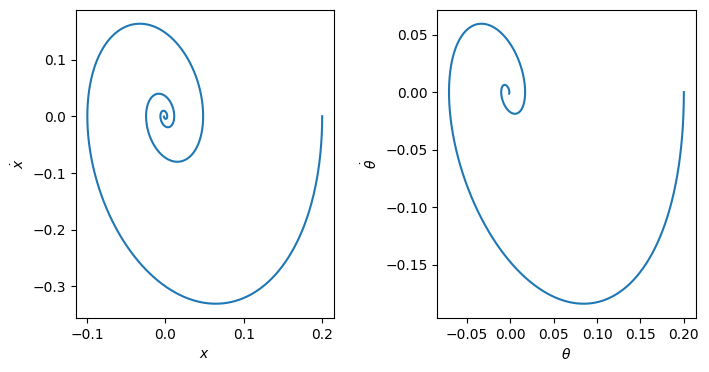

In [10]:
# Plot the results.
log = logger.FindLog(simulator.get_context())
t = log.sample_times()

fig, (ax_x, ax_th) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.4)

d = log.data()

ax_x.plot(d[0, :], d[2, :])
ax_x.set_xlabel(r"$x$")
ax_x.set_ylabel(r"$\dot{x}$")

ax_th.plot(d[1, :], d[3, :])
ax_th.set_xlabel(r"$\theta$")
ax_th.set_ylabel(r"$\dot{\theta}$")

#### Save recording as mp4 and gif files
1. mp4
    - Meshcat exports a sequence of png files
        - I'm not sure if tutorials mention this. But once a Meshcat recording is published, you can record a video (export image files)
    - `ffmpeg -r 60 -i %07d.png -vcodec libx264 -preset slow -crf 18 output.mp4`
        - to generate a mp4 file
2. gif
    - create a gif file using `imageio`
    - each snapshot is resized to (266, 255) using `PIL`

In [11]:
Image(url='./Media/cartpole.gif')  
